## Updated Distribution Score
The following code calculates the distribution score for all data points in the set

### Loading in all training and evaluation data

In [6]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

tr_data = []  # Empty list to hold TR data
vl_data = []  # Empty list to hold VL data
memorization_score = []  # Empty list to hold memorization scores

data_path = '/Users/ilanastern/Documents/GitHub/aiConfidential/data' 

# Walk through all directories and subdirectories in the 'data' folder
for root, dirs, files in os.walk(data_path):
    if root.endswith('_TR.eval') or root.endswith('_VL.eval'): # Check if we are in a TR.eval or VL.eval folder
        for file in files:
            if file.startswith('eval_loss_meta'): # Check if the file is 'eval_loss_meta'
                file_path = os.path.join(root, file)
                # Read the file into a DataFrame
                df = pd.read_csv(file_path)
                # Append to the appropriate list
                if root.endswith('_TR.eval'):
                    tr_data.append(df)
                elif root.endswith('_VL.eval'):
                    vl_data.append(df)

# Concatenate all dataframes into one for TR and one for VL
tr_df = pd.concat(tr_data, ignore_index=True)
vl_df = pd.concat(vl_data, ignore_index=True)



### Calculating the memorization score for every index

In [9]:
#Avergaing the f1 scores for each idx in both the TR and VL dataframes
tr_avg_f1 = tr_df.groupby('idx')['f1'].mean().reset_index()
tr_avg_f1.rename(columns={'f1': 'tr_avg_f1'}, inplace=True)
vl_avg_f1 = vl_df.groupby('idx')['f1'].mean().reset_index()
vl_avg_f1.rename(columns={'f1': 'vl_avg_f1'}, inplace=True)

memscore_df = pd.merge(tr_avg_f1, vl_avg_f1, on='idx')# Combining the TR and VL dataframes into one

# Get memorization score
memscore_df['Memorization_Score'] = merged_df['tr_avg_f1'] - merged_df['vl_avg_f1'] # Subtract the VL F1 score from the TR F1 score for each idx
print(memscore_df)

        idx  tr_avg_f1  vl_avg_f1  Memorization_Score
0      1029   0.551358   0.434499            0.116858
1      1398   0.545210   0.425472            0.119737
2      1649   0.538877   0.456238            0.082638
3      2241   0.551195   0.504534            0.046661
4      2725   0.524128   0.439365            0.084763
...     ...        ...        ...                 ...
2838  40605   0.998698   0.866706            0.131992
2839  40615   0.992850   0.977049            0.015801
2840  40616   0.999640   0.970385            0.029255
2841  40620   0.985778   0.924720            0.061058
2842  40623   0.999995   0.999993            0.000001

[2843 rows x 4 columns]


### Calculating the Simmilarity Score from the pickle package (same process as in orginal Distribution Score Data)

In [25]:
# Open the pickle file in read-binary mode and load the data
with open('/Users/ilanastern/Documents/GitHub/aiConfidential/nr80-vs-nr80.rnaforester.alnIdentity_pairwise.pkl', 'rb') as file:
    data = pickle.load(file)

pickle_df = pd.DataFrame(data)  # Renamed file to 'pickle_df'

# Rename idx values to stop before the first underscore so idx values match up to memorization score data
pickle_df.index = data_df.index.map(lambda x: str(x).split('_', 1)[0])
pickle_df.columns = data_df.columns.map(lambda x: str(x).split('_', 1)[0])

# Constants for the exponential decay function that I used to model the distribution scores, Values closest to 1 have the highest points (10)
#The function is A * exp(-B * (1 - score)) Values of 0.9 are worth 1 point. A score of 0 is worth 0 points.

A = 10  # Maximum points for the highest score (close to 1)
B = np.log(A / 1) / (1 - 0.9)  # Solve for B based on the condition that 0.9 maps to 1 point

# Function to map similarity score to points based on the new rules
def map_similarity_to_points(score):
    if pd.isna(score):  # Ignore NaN values
        return 0
    elif score >= 1:  # Ignore scores that are 1 or greater
        return 0
    elif score < 0.0:  # Return 0 points for scores less than 0
        return 0
    else:  # Apply the exponential decay function for scores between 0.5 and 1
        return A * np.exp(-B * (1 - score))

similarity_scores = {} # Empty dictionary to hold similarity scores

for idx, row in pickle_df.iterrows(): # Iterate over each row (which corresponds to an 'idx')
    points = row.apply(map_similarity_to_points).sum() # Apply the mapping function to each similarity score in the row and sum the points, ignoring NaN
    similarity_scores[idx] = points # Store the total points as the overall similarity score for each idx

similarity_scores_df = pd.DataFrame(list(similarity_scores.items()), columns=['idx', 'similarity_score']) # Convert the results to a DataFrame
print(similarity_scores_df)


        idx  similarity_score
0     34661          0.607089
1     31262          0.687699
2     37294          0.054929
3     34263          0.636044
4     27176          0.083809
...     ...               ...
3408  26367          0.051172
3409  31446          0.132740
3410  28360          0.140623
3411  27863          0.074165
3412  17264          0.223183

[3413 rows x 2 columns]


### Graphing the relationship between simmilarity score and memorization score as an exponential decay function

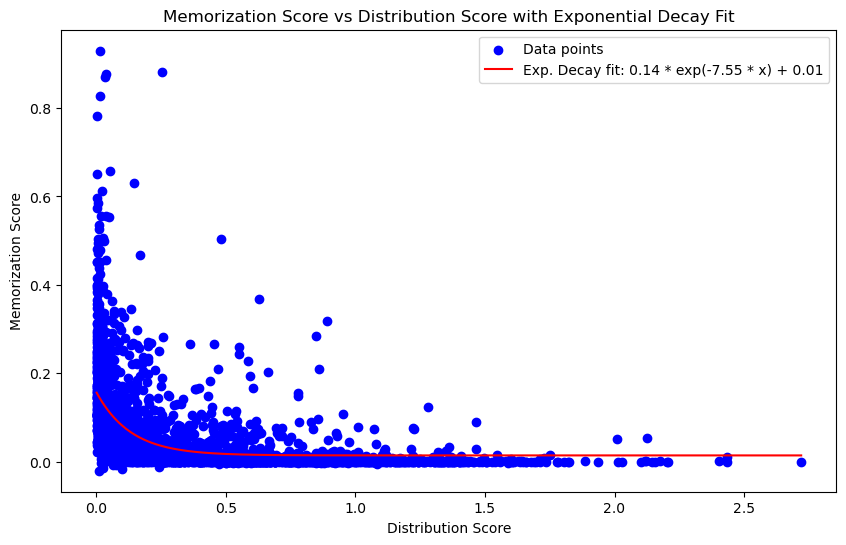

The exponential decay equation is: y = 0.14 * e^(-7.55 * x) + 0.01


In [26]:
memscore_df['idx'] = memscore_df['idx'].astype(str) #ensuring both dataframes have the same data type for the idx column
similarity_scores_df['idx'] = similarity_scores_df['idx'].astype(str)

# Merging the two dataframes so each idx has a memorization score and a similarity score
merged_df = pd.merge(memscore_df, similarity_scores_df, on='idx', how='inner')

def exp_decay(x, a, b, c): # Exponential decay function to fit the data
    return a * np.exp(-b * x) + c

# Fitting data
x = merged_df['similarity_score']
y = merged_df['Memorization_Score']
initial_guess = [1, 1, 1]  # Initial guess for parameters a, b, c
params, covariance = curve_fit(exp_decay, x, y, p0=initial_guess)
x_fit = np.linspace(min(x), max(x), 500) # Generate x values for the fitted curve
y_fit = exp_decay(x_fit, *params)

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_fit, y_fit, color='red', label=f'Exp. Decay fit: {params[0]:.2f} * exp(-{params[1]:.2f} * x) + {params[2]:.2f}')
plt.xlabel('Distribution Score')
plt.ylabel('Memorization Score')
plt.title('Memorization Score vs Distribution Score with Exponential Decay Fit')
plt.legend()
plt.show()
print(f'The exponential decay equation is: y = {params[0]:.2f} * e^(-{params[1]:.2f} * x) + {params[2]:.2f}')
